In [1]:
from moviepy import VideoFileClip

VideoFileClip('hong.gif').write_videofile('hong_test.mp4')

{'video_found': True, 'audio_found': False, 'metadata': {}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [360, 640], 'bitrate': None, 'fps': 33.33, 'codec_name': 'gif', 'profile': None}], 'input_number': 0}], 'duration': 12.27, 'bitrate': 41894, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'gif', 'video_profile': None, 'video_size': [360, 640], 'video_bitrate': None, 'video_fps': 33.33, 'video_duration': 12.27, 'video_n_frames': 408}
/mnt/d/naver_boostcamp/project/level4-cv-finalproject-hackathon-cv-19-lv3/.venv/lib/python3.10/site-packages/imageio_ffmpeg/binaries/ffmpeg-linux64-v4.2.2 -i hong.gif -loglevel error -f image2pipe -vf scale=360:640 -sws_flags bicubic -pix_fmt rgb24 -vcodec rawvideo -
MoviePy - Building video hong_test.mp4.
MoviePy - Writing video hong_test.mp4



MoviePy - Done !
MoviePy - video ready hong_test.mp4


# video generation test

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt


# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose
# Setting up the Pose model for images.
pose_img = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)
# Setting up the Pose model for videos.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, 
                          min_tracking_confidence=0.5, model_complexity=1)

# Initializing mediapipe drawing class to draw landmarks on specified image.
mp_drawing = mp.solutions.drawing_utils


def estimPose_img(input_file, pose=pose_img, landmarks_c=(234,63,247), connection_c=(117,249,77), 
                   thickness=20, circle_r=10, display=True):
    
    # Read the input image
    if isinstance(input_file, str) :
        input_img = cv2.imread(input_file)
    else :
        input_img = input_file
    
    # Create a copy of the input image
    output_img = input_img.copy()
    
    # Perform the Pose Detection.
    results = pose.process(output_img) # 이거 이렇게 하면 트래킹은 안되자나..
    # Retrieve the height and width of the input image.
    height, width, _ = input_img.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
        skeleton = np.zeros_like(input_img)
        mp_drawing.draw_landmarks(skeleton, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                  mp_drawing.DrawingSpec(landmarks_c, thickness, circle_r),
                                  mp_drawing.DrawingSpec(connection_c, thickness, circle_r))
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(output_img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                  mp_drawing.DrawingSpec(landmarks_c, thickness, circle_r),
                                  mp_drawing.DrawingSpec(connection_c, thickness, circle_r))
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_world_landmarks.landmark:
            landmarks.append((landmark.x, landmark.y,
                                  landmark.z, landmark.visibility))
            
    # print(results.pose_landmarks)
    # Check if we want to display.
    if display:
        # Display the original input image and the resulting image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(input_img[:,:,::-1]);plt.title("Original image");plt.axis('off')
        plt.subplot(122);plt.imshow(output_img[:,:,::-1]);plt.title("Output image");plt.axis('off')
        
        # Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        return output_img, skeleton, landmarks
        
    # Just get output_img and landmarks
    else:
        # Return the output image and the found landmarks.
        return output_img, skeleton, landmarks

def estimPose_video(input_file, pose_video=pose_video, landmarks_c=(234,63,247), connection_c=(117,249,77), 
                 thickness=1, circle_r=1, nrows_frames=4, ncols_frames=3):
    
    # Initialize the VideoCapture object to read from a video stored in the disk.
    video = cv2.VideoCapture(input_file)
    
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    frames = []
    original_video_frames = []
    only_skeleton_frames = []
    
    all_landmarks = []
    for i in range(total_frames):
        # Read a frame.
        ok, frame = video.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        original_video_frames.append(frame.copy())
    
        # Check if frame is not read properly.
        if not ok:
            # Break the loop.
            break
        
        # Get the width and height of the frame
        frame_height, frame_width, _ =  frame.shape
        # Resize the frame while keeping the aspect ratio.
        frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
        frame, skeleton, landmarks = estimPose_img(frame, pose_video, landmarks_c, connection_c, thickness, 
                              circle_r, display=False)
        frames.append(frame)
        all_landmarks.append(landmarks)
        only_skeleton_frames.append(skeleton)
    return original_video_frames, only_skeleton_frames, frames, all_landmarks

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737042044.078205   27678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737042044.079003   27673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737042044.157387   27679 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737042044.159680   27673 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [2]:
original_video_frames, only_skeleton_frames, frames, _ = estimPose_video("../hong.mp4", thickness=5)

W0000 00:00:1737042047.055806   27678 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [3]:
len(frames)

409

In [4]:
H, W, C = frames[0].shape
fps = 30
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (W, H))

for frame in frames:
    out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()

In [4]:
import imageio.v3 as iio

output_path = "test.mp4"
iio.imwrite(output_path, frames, fps=30)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (360, 640) to (368, 640) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x34b6bbc0] Warning: data is not aligned! This can lead to a speed loss


# image similarity

In [5]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

I0000 00:00:1737080919.901848   26860 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1737080919.960923   43760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737080920.040296   43759 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


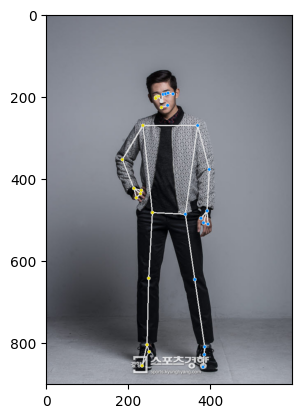

In [42]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

def get_detection(img_path):
    base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
    options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        output_segmentation_masks=True)
    detector = vision.PoseLandmarker.create_from_options(options)
    # # STEP 3: Load the input image.
    # image = mp.Image.create_from_file(img_path)
    # print(image.width, image.height)
    # print(image.numpy_view().shape)
    # # STEP 4: Detect pose landmarks from the input image.
    # detection_result = detector.detect(image)
    # annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    detection_result = detector.detect(mp_image)
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
    plt.imshow(annotated_image)
    plt.show()
    
    return detection_result.pose_landmarks, detection_result.segmentation_masks, annotated_image
r, s, a = get_detection('../target_img.jpg')

In [27]:
import numpy as np

def get_area(segmentation_masks, thr=0.5):
    return np.sqrt(np.sum(segmentation_masks.numpy_view() > thr))

def refine_landmarks(landmarks):
    lst = []
    for landmark in landmarks:
        lst.append([landmark.x, landmark.y, landmark.z])
    return np.array(lst)

I0000 00:00:1737080925.380995   26860 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1737080925.436113   43805 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737080925.507444   43806 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


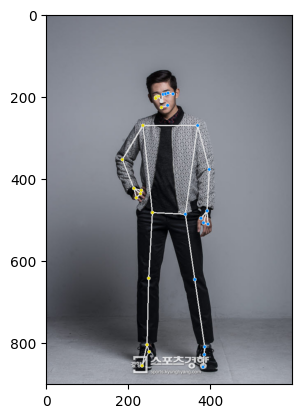

I0000 00:00:1737080925.803598   26860 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1737080925.849194   43813 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737080925.919649   43814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


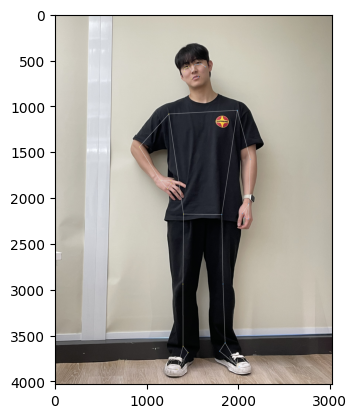

I0000 00:00:1737080926.969098   26860 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1737080927.017562   43824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737080927.063224   43823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


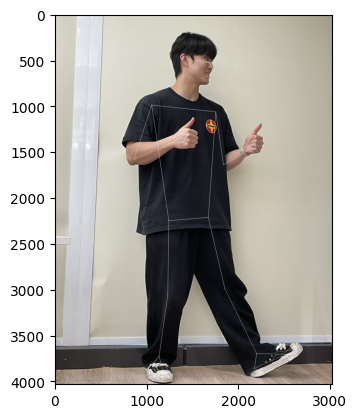

In [43]:
target_landmarks, target_masks, target_annotated_image = get_detection("../target_img.jpg")
target_landmarks_np = refine_landmarks(target_landmarks[0])
target_area = get_area(target_masks[0])

right_landmarks, right_masks, right_annotated_image = get_detection("../right_pose_img.jpg")
right_landmarks_np = refine_landmarks(right_landmarks[0])
right_area = get_area(right_masks[0])

wrong_landmarks, wrong_masks, wrong_annotated_image = get_detection("../wrong_pose_img.jpg")
wrong_landmarks_np = refine_landmarks(wrong_landmarks[0])
wrong_area = get_area(wrong_masks[0])

In [44]:
from keypoint_map import *

normalized_target_landmarks_np = normalize_landmarks(target_landmarks_np)
normalized_right_landmarks_np =  normalize_landmarks(right_landmarks_np)
normalized_wrong_landmarks_np =  normalize_landmarks(wrong_landmarks_np)

# normalized_target_landmarks_np = filter_important_features(normalize_landmarks(target_landmarks_np))
# normalized_right_landmarks_np = filter_important_features(normalize_landmarks(right_landmarks_np))
# normalized_wrong_landmarks_np = filter_important_features(normalize_landmarks(wrong_landmarks_np))

### GPT가 알려준 유클리드 거리 점수

In [45]:
def calculate_similarity(landmarks1, landmarks2):
    if landmarks1 is None or landmarks2 is None:
        return 0  # 비교 불가 시 유사성 0으로 처리

    # 평준화된 유클리드 거리 계산
    distance = np.linalg.norm(landmarks1 - landmarks2, axis=1)
    similarity = 1 / (1 + np.mean(distance))  # 유사성을 0~1로 정규화
    return similarity

print("target and right pose L1 score : ", calculate_similarity(normalized_target_landmarks_np, normalized_right_landmarks_np))
print("target and wrong pose L1 score : ", calculate_similarity(normalized_target_landmarks_np, normalized_wrong_landmarks_np))

target and right pose L1 score :  0.4926594997062135
target and wrong pose L1 score :  0.5154925152271372


### cosine similarity

In [46]:
def cos_sim(A, B):
  return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

print(f"target and right pose sim : {cos_sim(normalized_target_landmarks_np.flatten(), normalized_right_landmarks_np.flatten())}")
print(f"target and wrong pose sim : {cos_sim(normalized_target_landmarks_np.flatten(), normalized_wrong_landmarks_np.flatten())}")

target and right pose sim : 0.8497208745425023
target and wrong pose sim : 0.7105761830116205


In [50]:
print(f"target and right pose sim : {cos_sim(target_landmarks_np.flatten(), right_landmarks_np.flatten())}")
print(f"target and wrong pose sim : {cos_sim(target_landmarks_np.flatten(), wrong_landmarks_np.flatten())}")

target and right pose sim : 0.9425755985289069
target and wrong pose sim : 0.8646241699489815


### L2 norm

In [13]:
print("target and right pose L2 distance : ", np.linalg.norm((normalized_target_landmarks_np - normalized_right_landmarks_np).flatten()))
print("target and wrong pose L2 distance : ", np.linalg.norm((normalized_target_landmarks_np - normalized_wrong_landmarks_np).flatten()))

target and right pose L2 distance :  10.87030484537105
target and wrong pose L2 distance :  9.709593321910335


### L1 norm

In [14]:
print("target and right pose L1 distance : ", np.linalg.norm((normalized_target_landmarks_np - normalized_right_landmarks_np).flatten(), ord=1))
print("target and wrong pose L1 distance : ", np.linalg.norm((normalized_target_landmarks_np - normalized_wrong_landmarks_np).flatten(), ord=1))

target and right pose L1 distance :  94.1826755099271
target and wrong pose L1 distance :  79.52478900563351


### weighted distance

In [15]:
NUM_CLASSES = 33
def weighted_distance(A, B, weights = weights):
    d = 0.0

    for i in range(NUM_CLASSES):
        d += weights[keypoint_mapping[i]] * np.linalg.norm(A[i] - B[i], ord=1)
    return d

print("target and right pose weighted L1 distance : ", weighted_distance(normalized_target_landmarks_np, normalized_right_landmarks_np))
print("target and wrong pose weighted L1 distance : ", weighted_distance(normalized_target_landmarks_np, normalized_wrong_landmarks_np))

target and right pose weighted L1 distance :  2.4798999136030475
target and wrong pose weighted L1 distance :  2.1162673480715126


# Video Similarity

In [16]:
import mediapipe as mp
import cv2

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='pose_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO)

def get_video_detection(video_path, landmarks_c=(234,63,247), connection_c=(117,249,77), 
                   thickness=20, circle_r=10):
    with PoseLandmarker.create_from_options(options) as landmarker:
        video = cv2.VideoCapture(video_path)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(video.get(cv2.CAP_PROP_FPS))
        frame_duration = int(1000 / fps)
        frames = []
        landmarks = []

        for i in range(total_frames):
            # Read a frame.
            ok, frame = video.read()
            frame_timestamp_ms = i * frame_duration

            # Check if frame is not read properly.
            if not ok:
                # Break the loop.
                break

            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            pose_landmarker_result = landmarker.detect_for_video(mp_image, frame_timestamp_ms)
            frames.append(draw_landmarks_on_image(mp_image.numpy_view(), pose_landmarker_result))
            landmarks.append(pose_landmarker_result.pose_world_landmarks[0])
    return frames, landmarks

In [17]:
mara_1_frames, mara_1_landmarks = get_video_detection("../마라탕후루1.mp4")

I0000 00:00:1737079128.209808   26860 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1737079128.788533   30675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737079129.329713   30680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [18]:
mara_2_frames, mara_2_landmarks = get_video_detection("../마라탕후루2.mp4")

I0000 00:00:1737079193.489454   26860 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1737079193.989419   31151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737079194.714251   31150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [19]:
enter_frames, enter_landmarks = get_video_detection("../엔터테이먼트.mp4")

I0000 00:00:1737079254.968091   26860 task_runner.cc:85] GPU suport is not available: INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:77) display != EGL_NO_DISPLAYeglGetDisplay() returned error 0x300c
W0000 00:00:1737079255.445945   31607 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737079255.996635   31608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [20]:
min_length = min(len(mara_1_frames), len(mara_2_frames), len(enter_frames))

refined_mara_1_landmarks = [refine_landmarks(landmark) for landmark in mara_1_landmarks][:min_length]
refined_mara_2_landmarks = [refine_landmarks(landmark) for landmark in mara_2_landmarks][:min_length]
refined_enter_landmarks = [refine_landmarks(landmark) for landmark in enter_landmarks][:min_length]

In [22]:
def cos_sim(A, B):
  return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

mara_1_2_sim = np.mean([cos_sim(lm1.flatten(), lm2.flatten()) for lm1, lm2 in zip(refined_mara_1_landmarks, refined_mara_2_landmarks)])
mara_1_enter_sim = np.mean([cos_sim(lm1.flatten(), lm2.flatten()) for lm1, lm2 in zip(refined_mara_1_landmarks, refined_enter_landmarks)])

print(f"target and right pose sim : {mara_1_2_sim}")
print(f"target and wrong pose sim : {mara_1_enter_sim}")

target and right pose sim : 0.939370945475819
target and wrong pose sim : 0.9460680271229979


In [23]:
[cos_sim(lm1.flatten(), lm2.flatten()) for lm1, lm2 in zip(refined_mara_1_landmarks, refined_mara_2_landmarks)]

[0.8939329943392854,
 0.891726923336885,
 0.8872158481944269,
 0.8921959509816674,
 0.8948054358934958,
 0.8928353177501148,
 0.8906807769106295,
 0.8902654896647216,
 0.8905693327251617,
 0.8880465128101613,
 0.8877830085802506,
 0.8835935774192168,
 0.8843860026738701,
 0.8846359060468342,
 0.8903317082763266,
 0.887467336463807,
 0.8919834914853687,
 0.8952907578110265,
 0.9030453731239974,
 0.9063786258863664,
 0.9059604278628096,
 0.905272690419139,
 0.9036783021761201,
 0.9022597241020087,
 0.904671701874766,
 0.9042761107202121,
 0.9041661946176893,
 0.9007392513191089,
 0.8942259445758363,
 0.890359801979218,
 0.8880645023759611,
 0.8882733865114086,
 0.8898059535934966,
 0.8949469945187216,
 0.8988898802974913,
 0.8975025304094272,
 0.89771212794259,
 0.90124780923953,
 0.9030614121840177,
 0.903915134745503,
 0.9033596249052813,
 0.9039141117705125,
 0.904658913148043,
 0.9040550921744568,
 0.9055944642149749,
 0.9068345496246917,
 0.9075868821386299,
 0.9086355187388838,
 0.